In [2]:
#plotting and data analysis for global cold wakes
#from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
####################you will need to change some paths here!#####################
#list of input directories
dir_storm_info='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
dir_flux = 'F:/data/model_data/oaflux/data_v3/daily/turbulence/'
dir_cmc = 'F:/data/sst/cmc/CMC0.2deg/v2/'
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
##where to get the data through opendap, use these directories instead
#dir_cmc = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/CMC/CMC0.1deg/v3/'
#dir_flux = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/WHOI_OAFlux/version3/daily/lh_oaflux/'
#the latest ccmp is from www.remss.com but they do not have an opendap server so you can use this instead:
#dir_ccmp='https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/'

#################################################################################
import geopy.distance
from math import sin, pi
from scipy import interpolate

#functions for running storm data
import sys
#sys.path.append('C:/Users/gentemann/Google Drive/d_drive/python/storm_heat_content/subroutines/')
#from storm_masking_routines import interpolate_storm_path
#from storm_masking_routines import get_dist_grid
#from storm_masking_routines import closest_dist
#from storm_masking_routines import calculate_storm_mask



In [ ]:

#plot output data and mask

import os
dir_out_figures = 'F:/data/tc_wakes/database/figs/check_storm_dist/'
iyr_storm,inum_storm = 2003,27
for inum_storm in range(1,58): #100):
    filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
    exists = os.path.isfile(filename)
    if not exists:
        continue
    print(filename)
    ds_storm=xr.open_dataset(filename)
    ds_storm = ds_storm.sel(j2=0)
    ds_storm.close()
#    ds_storm['lon'] = (ds_storm.lon + 180) % 360 - 180
    filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
    ds_all = xr.open_dataset(filename)
    ds_all.close()
    #ds_all = ds_all.sortby('lon')
    print(ds_all.lon[0].values,ds_all.lon[-1].values)
    if abs(ds_all.lon[-1]-ds_all.lon[0])>180:
        ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
        #ds_all = ds_all.sortby(ds_all.lon)
        ds_storm['lon'] = np.mod(ds_storm['lon'], 360)
        #ds_storm = ds_storm.sortby(ds_storm.lon)
    plt.figure(figsize=(15,3.5))
    plt.subplot(131)
    ds_all.side_of_storm.plot()
    plt.plot(ds_storm.lon,ds_storm.lat,'w')
    plt.plot(ds_storm.lon[0],ds_storm.lat[0],'w*')
    plt.subplot(132)
    ds_all.dist_from_storm_km.plot(vmin=0,vmax=3000)
    plt.plot(ds_storm.lon,ds_storm.lat,'w')
    max_lat = ds_storm.lat.max()
    if max_lat<0:
        cond = ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm<=0)) |  ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm>0))
    else:
        cond = ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) |  ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))
    subset = ds_all.where(cond)
    plt.subplot(133)
    subset.dist_from_storm_km.plot(vmin=0,vmax=3000)
    plt.plot(ds_storm.lon,ds_storm.lat,'w')
    filename = dir_out_figures + str(iyr_storm) + str(inum_storm).zfill(3) + '_interpolated_track.png'
    plt.savefig(filename,dpi=100,bbox_inches='tight')
    plt.close()

In [ ]:
sum7=np.zeros(50)
print(sum7[0],sum7[49])

In [3]:

# coding: utf-8

# In[1]:


#plotting and data analysis for global cold wakes
#from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
import geopy.distance
from math import sin, pi
from scipy import interpolate

#functions for running storm data
import sys

####################you will need to change some paths here!#####################
#list of input directories
dir_storm_info='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
#################################################################################

#start to look at data and make some pdfs

date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958

#init arrays
init_data=0
num1=np.zeros([101,101,201,101])
sum1=np.zeros([101,101,201,101])
num2=np.zeros([101,101,201,101])
sum2=np.zeros([101,101,201,101])
num3=np.zeros(101)
num4=np.zeros(101)
num5=np.zeros(101)
sum5=np.zeros(101)
num6=np.zeros(101)
sum6=np.zeros(101)
sum7=np.zeros(101)
num7=np.zeros(101)
dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8=np.zeros(101),np.zeros(101),np.zeros(101),np.zeros(101),np.zeros(101),np.zeros(201),np.zeros(101),np.zeros(101)

map_lats=np.arange(-90,90,.25)
map_lons=np.arange(-180,180,.25)
imap_lats = map_lats.size
imap_lons = map_lons.size
map_sum,map_cnt,map_max = np.zeros([imap_lats,imap_lons]),np.zeros([imap_lats,imap_lons]),np.zeros([imap_lats,imap_lons])
  
iyr_storm = 2003
for inum_storm in range(65,66): #(0,100): #100):
    filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
    exists = os.path.isfile(filename)
    if not exists:
        continue
    print(filename)
    ds_storm_info=xr.open_dataset(filename)
    ds_storm_info = ds_storm_info.sel(j2=0)
    ds_storm_info.close()
    filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data_all.nc'
    ds_all = xr.open_dataset(filename)
    ds_all['spd']=np.sqrt(ds_all.uwnd**2+ds_all.vwnd**2)
    ds_all.close()
    if abs(ds_all.lon[-1]-ds_all.lon[0])>180:
        ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
        ds_storm_info['lon'] = np.mod(ds_storm_info['lon'], 360)
    max_lat = ds_storm_info.lat.max()
    #remove all data outsice 100km/800km or cold wake >0 or <-10
    if max_lat<0:
        cond = ((((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm<=0)) | 
        ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm>0))) 
        & (ds_all.coldwake_max<=0) & (ds_all.coldwake_max>=-10))
    else:
        cond = ((((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) | 
        ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))) 
        & (ds_all.coldwake_max<=0) & (ds_all.coldwake_max>=-10))
    subset = ds_all.where(cond)

    xdim,ydim,tdim = ds_all.lon.shape[0],ds_all.lat.shape[0],ds_all.time.shape[0]
    
    #change hr to recovery to day to recovery
    subset['coldwake_dytorecovery'] = subset.coldwake_hrtorecovery/24.
    
    #calculate the historgram and mean for the cold wakes
    cbin1 = np.arange(-10, 0, 0.1)  #cold wake bins
    subset_sum1=subset.groupby_bins('coldwake_max',cbin1).sum()  #sums number
    subset_cnt1=subset.groupby_bins('coldwake_max',cbin1).count()    #sums variable  
    cbin2 = np.arange(0,24*6)  #hour to max
    subset_sum2=subset.groupby_bins('coldwake_hrtomaxcold',cbin2).sum()  #sums number
    subset_cnt2=subset.groupby_bins('coldwake_hrtomaxcold',cbin2).count()    #sums variable
    cbin3 = np.arange(0,50)  #dy to recovery
    subset_sum3=subset.groupby_bins('coldwake_dytorecovery',cbin3).sum()  #sums number
    subset_cnt3=subset.groupby_bins('coldwake_dytorecovery',cbin3).count()    #sums variable
    cbin4 = np.arange(0,500)  #mld
    subset_sum4=subset.groupby_bins('dbss_obml',cbin4).sum()  #sums number
    subset_cnt4=subset.groupby_bins('dbss_obml',cbin4).count()    #sums variable
    cbin5 = np.arange(0,200)  #mld
    subset_sum5=subset.groupby_bins('spd',cbin5).sum()  #sums number
    subset_cnt5=subset.groupby_bins('spd',cbin5).count()    #sums variable

    sdate = np.empty([ydim,xdim], dtype=dt.datetime)    
    for i in range(0,xdim):
        for j in range(0,ydim):
            sdate[j,i] = np.datetime64(date_1858 + dt.timedelta(days=float(ds_all.closest_storm_time[j,i])))
    #xsdate=xr.DataArray(sdate, coords={'lat': ds_data.lat.values, 'lon':ds_data.lon.values}, dims=('lat', 'lon'))        
    sdate2 = np.empty([tdim,ydim,xdim])    
    for i in range(0,xdim):
        for j in range(0,ydim):
            if np.isnan(subset.analysed_sst[0,j,i]):  #don't process masked values
                continue
            for k in range(0,tdim):
                sdate2[k,j,i] = (ds_all.time[k] - sdate[j,i]) / np.timedelta64(1,'D')
    xsdate2=xr.DataArray(sdate2, coords={'time':ds_all.time, 'lat': ds_all.lat.values, 'lon':ds_all.lon.values}, dims=('time','lat', 'lon'))        
    ds_all['dys_from_storm2']=xsdate2
    cbin6 = np.arange(-10,50,1)  #cold wake bins
    subset_sum6=ds_all.groupby_bins('dys_from_storm2',cbin6).sum()  #sums number
    subset_cnt6=ds_all.groupby_bins('dys_from_storm2',cbin6).count()    #sums variable  

        #start saving this data
    if init_data == 0:
        sv_sum1,sv_cnt1 = subset_sum1,subset_cnt1
        sv_sum2,sv_cnt2 = subset_sum2,subset_cnt2
        sv_sum3,sv_cnt3 = subset_sum3,subset_cnt3
        sv_sum4,sv_cnt4 = subset_sum4,subset_cnt4
        sv_sum5,sv_cnt5 = subset_sum5,subset_cnt5
        sv_sum6,sv_cnt6 = subset_sum6,subset_cnt6
        init_data=1
    else:
        sv_sum1+= subset_sum1
        sv_cnt1+= subset_cnt1
        sv_sum2+= subset_sum2
        sv_cnt2+= subset_cnt2
        sv_sum3+= subset_sum3
        sv_cnt3+= subset_cnt3
        sv_sum4+= subset_sum4
        sv_cnt4+= subset_cnt4
        sv_sum5+= subset_sum5
        sv_cnt5+= subset_cnt5      
        sv_sum6+= subset_sum6
        sv_cnt6+= subset_cnt6           

        #put on global map
    tem = subset.coldwake_max.interp(lat=map_lats,lon=map_lons)
    tem=tem.fillna(0)
    temc=(tem/tem).fillna(0)
    map_sum+=tem
    map_cnt+=temc
    map_max=np.where(tem.data < map_max, tem,map_max)  #where tem<max put tem value in otherwise leave max
        
    for i in range(0,xdim):
        for j in range(0,ydim):
            if np.isnan(subset.analysed_sst[0,j,i]):  #don't process masked values
                continue
            storm_date64 = np.datetime64(date_1858 + dt.timedelta(days=float(ds_all.closest_storm_time[j,i])))
            time_diff = subset.time-storm_date64
            storm_index = np.argmin(abs(time_diff)).data

#            map_sum[j,i]+=subset.coldwake_max[j,i]
#            map_cnt[j,i]+=1
#            if  map_max[j,i]>subset.coldwake_max[j,i]:
#                map_max[j,i]=subset.coldwake_max[j,i]
            
            if subset.coldwake_max[j,i]<-0.1:  #cold wake larger than -0.1 
                icold=int(np.round(subset.coldwake_max[j,i].data*10.))+10
                icoldhr=int(np.round(subset.coldwake_hrtomaxcold[j,i].data))
                icolddy2=int(np.round(subset.coldwake_hrtorecovery[j,i].data/24.))
                iswnd=int(np.round(subset.wmo_storm_wind[j,i].data*.5))
                iwnd=int(np.round(subset.spd[storm_index,j,i].data))
                isspd=int(abs(np.round(subset.wmo_storm_speed[j,i].data)))

            #PROBLEM MLD interpolation pre 1/1 for each year need to fix
            #for now just setting first data to 1/1 for each year
                im=0
                if np.isnan(subset.dbss_obml[im,j,i].data):
                    while np.isnan(subset.dbss_obml[im,j,i].data):
                        im+=1
                        if im>=tdim:
                            break
                if im>=tdim:
                    continue
                if np.isnan(subset.dbss_obml[im,j,i].data):
                    continue
                imld=int(np.round(subset.dbss_obml[im,j,i].data))

                if (icold<0) | (icold>100):  #cold wake max between 0,10 K
                    continue
                if (icold>=0) & (icold<=100) & (isspd>=0) & (isspd<=200) & (imld>=0) & (imld<=100):                
                    if (iswnd>=0) & (iswnd<=100):             
                        sum1[icold,iswnd,isspd,imld]=sum1[icold,iswnd,isspd,imld]+subset.coldwake_max[j,i].data  #uses storm wind from wmo track
                        num1[icold,iswnd,isspd,imld]=num1[icold,iswnd,isspd,imld]+1  #uses storm wind from wmo track
                    if (iwnd>=0) & (iwnd<=100):                  
                        sum2[icold,iwnd,isspd,imld]=sum2[icold,iwnd,isspd,imld]+subset.coldwake_max[j,i].data    #uses collocated ccmp wind on storm day
                        num2[icold,iwnd,isspd,imld]=num2[icold,iwnd,isspd,imld]+1    #uses collocated ccmp wind on storm day
 #               if (icoldhr>=0) & (icoldhr<100):
 #                   num3[icoldhr]=num3[icoldhr]+1   #pdf of when max cold wake occurs
 #               if (icolddy2>=0) & (icolddy2<100):
 #                   num4[icolddy2]=num4[icolddy2]+1   #pdf of when recovery occurs
    #            num4[icold] = num4[icold]+1                     
 #               sum5[icold]=sum5[icold]+subset.coldwake_hrtorecovery[j,i].data  #mean of recorvery time as f(max coldwake)
 #               num5[icold]=num5[icold]+1  #mean of recorvery time as f(max coldwake)
 #               if (icoldhr>=0) & (icoldhr<100):
 #                   sum6[icoldhr]=sum6[icoldhr]+subset.coldwake_max[j,i].data  #mean of max cold wake as f(hr from storm)
 #                   num6[icoldhr]=num6[icoldhr]+1  #mean of max cold wake as f(hr from storm)

                #caluclate the mean sst anomaly as f(days after storm)
 #               for k in range(storm_index,tdim):
 #                   data_time = subset.time[k]
 #                   dtime = data_time-storm_date64
 #                   ddy = dtime / np.timedelta64(1,'D')
 #                   iddy = int(np.round(ddy))
 #                   if (iddy<0) | (iddy>50):
 #                       continue
 #                   change_in_sst = subset.sst_prestorm[j,i].data-subset.analysed_sst[k,j,i].data
 #                   sum7[iddy]=sum7[iddy]+change_in_sst  
 #                   num7[iddy]=num7[iddy]+1  

    for i in range(0,100):
        dim1[i]=(i-10)/10
        dim2[i]=i
        dim3[i]=i*24
        dim4[i]=i/.5
        dim5[i]=i
        dim7[i]=i
        dim8[i]=i
    for i in range(0,200):
        dim6[i]=i
#                                'num3': (('coldhr'),num3),
#                                'num4': (('colddy'),num4),
#                                'sum5': (('cold'),sum5),
#                                'num5': (('cold'),num5),
#                                'sum6': (('coldhr'),sum6),
#                                'num6': (('coldhr'),num6),
#                               'sum7': (('dyfrom'),sum7),
#                                'num7': (('dyfrom'),num7)
 
    m1=xr.DataArray(map_sum, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        
    m2=xr.DataArray(map_cnt, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        
    m3=xr.DataArray(map_max, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        

    ds=xr.Dataset(data_vars={'sum1': (('cold','swnd','sspd','mld'),sum1),
                                'num1': (('cold','swnd','sspd','mld'),num1),
                                'sum2': (('cold','cwnd','sspd','mld'),sum2),
                                'num2': (('cold','cwnd','sspd','mld'),num2),
                                'map_sum': (('lat','lon'),m1),
                                'map_cnt': (('lat','lon'),m2),
                                'map_max': (('lat','lon'),m3)
                               },
                                 coords={'cold':dim1,'coldhr':dim2,'colddy':dim3,'swnd':dim4,
                                         'wnd':dim5,'sspd':dim6,'mld':dim7,'dyfrom':dim8,
                                         'lat':map_lats,'lon':map_lons})


f:/data/tc_wakes/database/sst/2003/065_interpolated_track.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\groupby.py:749: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\groupby.py:755: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  **kwargs)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\groupby.py:749: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\groupby.py:755: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pas

StopIteration: 

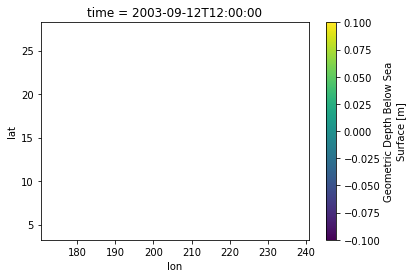

In [24]:
#subset.spd.max('time').plot()
#subset.coldwake_max.plot()
subset.dbss_obml[20,:,:].plot()
#subset.hum2m[0,:,:].plot()

In [25]:
subset.time

<xarray.DataArray 'time' (time: 53)>
array(['2003-08-23T12:00:00.000000000', '2003-08-24T12:00:00.000000000',
       '2003-08-25T12:00:00.000000000', '2003-08-26T12:00:00.000000000',
       '2003-08-27T12:00:00.000000000', '2003-08-28T12:00:00.000000000',
       '2003-08-29T12:00:00.000000000', '2003-08-30T12:00:00.000000000',
       '2003-08-31T12:00:00.000000000', '2003-09-01T12:00:00.000000000',
       '2003-09-02T12:00:00.000000000', '2003-09-03T12:00:00.000000000',
       '2003-09-04T12:00:00.000000000', '2003-09-05T12:00:00.000000000',
       '2003-09-06T12:00:00.000000000', '2003-09-07T12:00:00.000000000',
       '2003-09-08T12:00:00.000000000', '2003-09-09T12:00:00.000000000',
       '2003-09-10T12:00:00.000000000', '2003-09-11T12:00:00.000000000',
       '2003-09-12T12:00:00.000000000', '2003-09-13T12:00:00.000000000',
       '2003-09-14T12:00:00.000000000', '2003-09-15T12:00:00.000000000',
       '2003-09-16T12:00:00.000000000', '2003-09-17T12:00:00.000000000',
       '2003-0

In [ ]:
    if 10*(int(inum_storm/10))==inum_storm:
        filename='f:/data/tc_wakes/database/results/pdf'+str(iyr_storm)+'.nc'
        ds.to_netcdf(filename)
        print('output file',inum_storm, filename)
filename='f:/data/tc_wakes/database/results/pdf'+str(iyr_storm)+'.nc'
ds.to_netcdf(filename)
filename='f:/data/tc_wakes/database/results/sum1'+str(iyr_storm)+'.nc'
sv_sum1.coords['coldwake_max_bins'] = cbin1[0:-1]  # could also use assign_coords
sv_sum1.to_netcdf(filename)
filename='f:/data/tc_wakes/database/results/cnt1'+str(iyr_storm)+'.nc'
sv_cnt1.coords['coldwake_max_bins'] = cbin1[0:-1]  # could also use assign_coords
sv_cnt1.to_netcdf(filename)
filename='f:/data/tc_wakes/database/results/sum2'+str(iyr_storm)+'.nc'
sv_sum2.coords['coldwake_hrtomaxcold_bins'] = cbin2[0:-1]  # could also use assign_coords
sv_sum2.to_netcdf(filename)
filename='f:/data/tc_wakes/database/results/cnt2'+str(iyr_storm)+'.nc'
sv_cnt2.coords['coldwake_hrtomaxcold_bins'] = cbin2[0:-1]  # could also use assign_coords
sv_cnt2.to_netcdf(filename)
filename='f:/data/tc_wakes/database/results/sum3'+str(iyr_storm)+'.nc'
sv_sum3.coords['coldwake_dytorecovery_bins'] = cbin3[0:-1]  # could also use assign_coords
sv_sum3.to_netcdf(filename)
filename='f:/data/tc_wakes/database/results/cnt3'+str(iyr_storm)+'.nc'
sv_cnt3.coords['coldwake_dytorecovery_bins'] = cbin3[0:-1]  # could also use assign_coords
sv_cnt3.to_netcdf(filename)
filename='f:/data/tc_wakes/database/results/sum4'+str(iyr_storm)+'.nc'
sv_sum4.coords['dbss_obml_bins'] = cbin4[0:-1]  # could also use assign_coords
sv_sum4.to_netcdf(filename)
filename='f:/data/tc_wakes/database/results/cnt4'+str(iyr_storm)+'.nc'
sv_cnt4.coords['dbss_obml_bins'] = cbin4[0:-1]  # could also use assign_coords
sv_cnt4.to_netcdf(filename)
filename='f:/data/tc_wakes/database/results/sum5'+str(iyr_storm)+'.nc'
sv_sum5.coords['spd_bins'] = cbin5[0:-1]  # could also use assign_coords
sv_sum5.to_netcdf(filename)
filename='f:/data/tc_wakes/database/results/cnt5'+str(iyr_storm)+'.nc'
sv_cnt5.coords['spd_bins'] = cbin5[0:-1]  # could also use assign_coords
sv_cnt5.to_netcdf(filename)
filename='f:/data/tc_wakes/database/results/sum6'+str(iyr_storm)+'.nc'
sv_sum6.coords['dys_from_storm2_bins'] = cbin6[0:-1]  # could also use assign_coords
sv_sum6.to_netcdf(filename)
filename='f:/data/tc_wakes/database/results/cnt6'+str(iyr_storm)+'.nc'
sv_cnt6.coords['dys_from_storm2_bins'] = cbin6[0:-1]  # could also use assign_coords
sv_cnt6.to_netcdf(filename)
        


In [ ]:
plt.plot(cbin1[0:-1],sv_cnt1.coldwake_max)

In [ ]:
m1=xr.DataArray(sv_sum1, coords={'cbin1': cbin1}, dims=('cbin1'))        


In [ ]:
ds_all

In [ ]:
plt.plot(cbin1[0:-1],cwake_cnt1.coldwake_max)
#subset.coldwake_dytorecovery[40:80,75]

#subset.coldwake_hrtomaxcold[40:80,75]

In [ ]:
tem=np.empty([ydim,xdim], dtype=dt.datetime)    
for i in range(0,xdim):
        for j in range(0,ydim):
            tem[j,i] = np.datetime64(date_1858 + dt.timedelta(days=float(ds_all.closest_storm_time[j,i])))
ds_all['closest_storm_time64']=xr.DataArray(tem, coords={'lat': ds_all.lat.values, 'lon':ds_all.lon.values}, dims=('lat', 'lon'))        


In [ ]:
ds_all['closest_storm_time64']

In [ ]:
ds_all['time']

In [ ]:
plt.plot(sum7/num7)


In [ ]:
cbin = np.arange(-10, 0, 0.1)
icold=subset.coldwake_max*10.+10
#icoldhr=int(np.round(subset.coldwake_hrtomaxcold.data))
#icolddy2=int(np.round(subset.coldwake_hrtorecovery.data/24.))
#iswnd=int(np.round(subset.wmo_storm_wind.data*.5))
#iwnd=int(np.round(subset.spd.data))
#isspd=int(abs(np.round(subset.wmo_storm_speed.data)))
m=subset.groupby_bins('coldwake_max',cbin).mean()   #calculates mean
c=subset.groupby_bins('coldwake_max',cbin).count()  #sums number
s=subset.groupby_bins('coldwake_max',cbin).sum()    #sums variable

In [ ]:
print(m.coldwake_max[-2].values,s.coldwake_max[-2].values,c.coldwake_max[-2].values,s.coldwake_max[-2].values/c.coldwake_max[-2].values)

In [ ]:
iyr_storm = 2003
filename='f:/data/tc_wakes/database/results/pdf'+str(iyr_storm)+'.nc'
#plot the pdsf different ways
ds = xr.open_dataset(filename)
ds.close()
ds
ds.num7.plot()

In [ ]:
import geopy.distance
from math import sin, pi
import numpy as np
#this routine takes a point and finds distance to all points in a grid of lat and lon
#it is slowwwwwww
tdim_storm = ds_storm_info.time.size
storm_speed = ds_storm_info.time.copy(deep=True)*np.nan    
for i in range(0,tdim_storm-1):
    coords_1 = (ds_storm_info.lat[i], ds_storm_info.lon[i])  
    coords_2 = (ds_storm_info.lat[i+1], ds_storm_info.lon[i+1])  
    arclen_temp = geopy.distance.geodesic(coords_1, coords_2).km  #distance in km  
    storm_date1 = np.datetime64(date_1858 + dt.timedelta(days=float(ds_storm_info.time[i])))  #create new time array that can be queried for year etc
    storm_date2 = np.datetime64(date_1858 + dt.timedelta(days=float(ds_storm_info.time[i+1])))  #create new time array that can be queried for year etc
    arclen_time = storm_date2 - storm_date1
    arclen_hr = arclen_time / np.timedelta64(1, 'h')
    storm_speed[i]=arclen_temp/(arclen_hr)
storm_speed[-1]=storm_speed[-2]


In [ ]:
storm_speed

In [ ]:
ds_all = xr.open_dataset(filename)
ds_all['spd']=np.sqrt(ds_all.uwnd**2+ds_all.vwnd**2)
ds_all.close()
if abs(ds_all.lon[-1]-ds_all.lon[0])>180:
    ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
    ds_storm_info['lon'] = np.mod(ds_storm_info['lon'], 360)
max_lat = ds_storm_info.lat.max()
if max_lat<0:
    cond = ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm<=0)) |  ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm>0))
else:
    cond = ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) |  ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))
subset = ds_all.where(cond)
#subset now only has the data within 100 and 800 km of storm
xdim,ydim,tdim = ds_all.lon.shape[0],ds_all.lat.shape[0],ds_all.time.shape[0]
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
coldwake_max=ds_all.sst_prestorm.copy(deep=True)*np.nan
coldwake_delay=ds_all.sst_prestorm.copy(deep=True)*np.nan
for i in range(0,xdim):
    for j in range(0,ydim):
        storm_date = date_1858 + dt.timedelta(days=float(ds_all.closest_storm_time[j,i]))  #create new time array that can be queried for year etc
        storm_date64 = np.datetime64(storm_date)
        if np.isnan(subset.analysed_sst[0,j,i]):  #don't process masked values
            continue
        time_diff = subset.time-storm_date64
        storm_index = np.argmin(abs(time_diff)).data
        istart,iend = int(storm_index)-1,int(storm_index)+5
        if istart<0:
            istart=0
        if iend>tdim:
            iend=tdim
        coldwake_max[j,i] = (subset.sst_prestorm[j,i]-subset.analysed_sst[istart:iend,j,i]).min()
coldwake_max.plot()

In [ ]:
#(subset.sst_prestorm-subset.analysed_sst[0,:,:]).plot()  cold wake
xdim,ydim,tdim = ds_all.lon.shape[0],ds_all.lat.shape[0],ds_all.time.shape[0]
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
coldwake_max=ds_all.sst_prestorm.copy(deep=True)*np.nan
coldwake_maxindex=ds_all.sst_prestorm.copy(deep=True)*np.nan
coldwake_hrtomaxcold=ds_all.sst_prestorm.copy(deep=True)*np.nan
coldwake_recovery=ds_all.sst_prestorm.copy(deep=True)*np.nan
for i in range(0,xdim):
    for j in range(0,ydim):
        storm_date = date_1858 + dt.timedelta(days=float(ds_all.closest_storm_time[j,i]))  #create new time array that can be queried for year etc
        storm_date64 = np.datetime64(storm_date)
        if np.isnan(subset.analysed_sst[0,j,i]):  #don't process masked values
            continue
        time_diff = subset.time-storm_date64
        storm_index = np.argmin(abs(time_diff)).data
        istart,iend = int(storm_index)-1,int(storm_index)+5
        if istart<0:
            istart=0
        if iend>tdim:
            iend=tdim
        coldwake_max[j,i] = (subset.sst_prestorm[j,i]-subset.analysed_sst[istart:iend,j,i]).min()
        itmp = np.argmin(subset.sst_prestorm[j,i]-subset.analysed_sst[istart:iend,j,i]).data
        coldwake_maxindex[j,i]=istart+itmp
        delay = subset.time[istart+itmp].values-subset.time[istart+1].values
        coldwake_hrtomaxcold[j,i]=delay / np.timedelta64(1, 'h')
        for k in range(istart+itmp,tdim):
            sst_change = subset.sst_prestorm[j,i]-subset.analysed_sst[k,j,i]
            if sst_change>-0.2:
                break
        delay = subset.time[k].values-subset.time[istart+1].values
        coldwake_recovery[j,i]=delay / np.timedelta64(1, 'h')
        


In [ ]:
i,j = 100,100
coldwake_max=ds_all.sst_prestorm.copy(deep=True)*np.nan
coldwake_maxindex=ds_all.sst_prestorm.copy(deep=True)*np.nan
coldwake_hrtomaxcold=ds_all.sst_prestorm.copy(deep=True)*np.nan
coldwake_recovery=ds_all.sst_prestorm.copy(deep=True)*np.nan
storm_date = date_1858 + dt.timedelta(days=float(ds_all.closest_storm_time[j,i]))  #create new time array that can be queried for year etc
storm_date64 = np.datetime64(storm_date)
time_diff = subset.time-storm_date64
storm_index = np.argmin(abs(time_diff)).data
istart,iend = int(storm_index)-1,int(storm_index)+5
if istart<0:
    istart=0
if iend>tdim:
    iend=tdim
coldwake_max[j,i] = (subset.sst_prestorm[j,i]-subset.analysed_sst[istart:iend,j,i]).min()
itmp = np.argmin(subset.sst_prestorm[j,i]-subset.analysed_sst[istart:iend,j,i]).data
coldwake_maxindex[j,i]=istart+itmp
delay = subset.time[istart+itmp].values-subset.time[istart+1].values
coldwake_hrtomaxcold[j,i]=delay / np.timedelta64(1, 'h')
print(coldwake_hrtomaxcold[j,i])
for k in range(istart+itmp,tdim):
    sst_change = subset.sst_prestorm[j,i]-subset.analysed_sst[k,j,i]
    if sst_change>-0.2:
        break
delay = subset.time[k].values-subset.time[istart+1].values
coldwake_recovery[j,i]=delay / np.timedelta64(1, 'h')
print(coldwake_recovery[j,i].data)
print(subset.sst_prestorm[j,i]-subset.analysed_sst[istart+itmp:,j,i])


In [ ]:
print(ds_all.time[0])
plt.subplot(131)
plt.pcolormesh(ds_all.lon,ds_all.lat,ds_all.coldwake_max,vmin=-1,vmax=1)
plt.plot(ds_storm_info.lon+360,ds_storm_info.lat,'w')
plt.plot(ds_storm_info.lon[0]+360,ds_storm_info.lat[0],'r*')
plt.subplot(132)
plt.pcolormesh(subset.lon,subset.lat,subset.coldwake_max,vmin=-1,vmax=1)
plt.subplot(133)
plt.pcolormesh(coldwake_recovery/24,vmin=0,vmax=40)
plt.colorbar


In [ ]:
ds_storm_info

In [ ]:
for i in range(0,tdim):
    storm_date = date_1858 + dt.timedelta(days=float(ds_storm_info.time[i]))  #create new time array that can be queried for year etc
    print(storm_date)

In [ ]:
subset.sst_prestorm[40,100].data
i,j = 100,40
storm_date = date_1858 + dt.timedelta(days=float(ds_all.closest_storm_time[j,i]))  #create new time array that can be queried for year etc
storm_date64 = np.datetime64(storm_date)
#print(subset.time)
time_diff = subset.time-storm_date64
storm_index = np.argmin(abs(time_diff)).data
istart,iend = int(storm_index)-1,int(storm_index)+5
if istart<0:
    istart=0
if iend>tdim:
    iend=tdim
coldwake_max[j,i] = (subset.sst_prestorm[j,i]-subset.analysed_sst[istart:iend,j,i]).min()
itmp = np.argmin(subset.sst_prestorm[j,i]-subset.analysed_sst[istart:iend,j,i])
print(itmp)
print(subset.sst_prestorm[j,i].values,subset.analysed_sst[istart:iend,j,i].values)
print(istart,iend)
print(coldwake_max[j,i])

In [ ]:
(subset.sst_prestorm[j,i]-subset.analysed_sst[istart:iend,j,i]).plot()

In [ ]:
dir_out2 = 'F:/data/tc_wakes/database/sst/'
iyr_storm,inum_storm = 2003,2
filename = dir_out2 + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
dsint=xr.open_dataset(filename)
dsint.close()
filename = dir_out2 + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data_all.nc'
ds_all = xr.open_dataset(filename)
ds_all.close()
print(dsint.dims)
print(ds_all.closest_storm_index.min(),ds_all.closest_storm_index.max())




In [ ]:
dir_out

In [ ]:
ds_all.spd.max('time').plot()

In [ ]:
lyr=2003
filename='F:/data/tc_wakes/ibtracks/year/Year.'+str(lyr)+'.ibtracs_wmo.v03r10.nc'
ds_storm_info = xr.open_dataset(filename)
ds_storm_info.close()
ds_storm_info

In [ ]:
#test storm
isave_mld_year = 0 #init MLD monthly data read flag
for root, dirs, files in os.walk(dir_storm_info, topdown=False):
    if root[len(dir_storm_info):len(dir_storm_info)+1]=='.':
        continue
    for name in files:
        if not name.endswith('.nc'):
            continue
        filename=os.path.join(root, name)
        print(filename[36:39],filename[31:35])
        inum_storm=int(filename[36:39])
        iyr_storm=int(filename[31:35])

        
        if iyr_storm!=2003:
            continue
        if inum_storm!=5:
            continue
#        if iyr_storm==2002 and inum_storm<9:
#            continue
        
        
#        if iyr_storm!=2007: # or iyr_storm<2003:
#            continue
        print(name,filename)
        ds_storm_info = xr.open_dataset(filename)
        lats = ds_storm_info.lat[0,:]
        lons = ds_storm_info.lon[0,:]  #lons goes from 0 to 360
        lons = (lons + 180) % 360 - 180 #put -180 to 180
        dysince = ds_storm_info.time
        ds_storm_info.close()
        
#make lat and lon of storm onto 25 km grid for below
        lons = (((lons - .125)/.25+1).astype(int)-1)*.25+.125
        lats = (((lats + 89.875)/.25+1).astype(int)-1)*.25-89.875
        
        iwrap=0
#calculate size of box to get data in
        minlon,maxlon = min(lons.values)-10, max(lons.values)+10
        minlat,maxlat = min(lats.values)-10, max(lats.values)+10

        ydim_storm = round((maxlat - minlat)/.25).astype(int)
        new_lat_storm = np.linspace(minlat, maxlat, ydim_storm)
        if (minlon<-90 and maxlon>=90) or (minlon<-180 and maxlon<0):  #this storm wraps  keep everythig 0 to 360 then wrap data at very end
            iwrap = 1
            lons2 = np.mod(lons, 360)
            minlon, maxlon = min(lons2.values)-10, max(lons2.values)+10
            xdim_storm = round((maxlon - minlon)/.25).astype(int)
            new_lon_storm = np.linspace(minlon, maxlon, xdim_storm)
        else:
            xdim_storm = round((maxlon - minlon)/.25).astype(int)
            new_lon_storm = np.linspace(minlon, maxlon, xdim_storm)

        print(iwrap,minlon,maxlon)
        print(iwrap,xdim_storm, new_lon_storm[:5],new_lon_storm[-5:])

        
        date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
        dims=lats.shape
        tdim=dims[0]
        tem_date=[0]*tdim #print(dysince.values)
        for i in range(0,tdim):
            tem_date[i]=date_1858+dt.timedelta(days=float(dysince[0,i].values))  #create new time array that can be queried for year etc
        min_date = min(tem_date)+dt.timedelta(days=-5)
        max_date = max(tem_date)+dt.timedelta(days=5)
        minjdy = min_date.timetuple().tm_yday  #create new time array that can be queried for year etc
        minyear =min_date.year #create new time array that can be queried for year etc
        minmon =min_date.month #create new time array that can be queried for year etc
        minday =min_date.day #create new time array that can be queried for year etc
        maxjdy = max_date.timetuple().tm_yday  #create new time array that can be queried for year etc
        maxyear =max_date.year  #create new time array that can be queried for year etc
        print(minyear,minjdy,maxyear,maxjdy)
        
        dif = max(tem_date)-min(tem_date)
        tdim=int(dif.days)+30             #calculate ssts for 30 days after storm

        #print(tdim,xdim,ydim)            
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
        ds_all = xr.open_dataset(filename,drop_variables=['uwnd','vwnd','dbss_obml','lhtfl','shtfl','tmp2m ','hum2m','analysed_sst_clim'])
        ds_all.close()
        
#        ds_all = xr.merge([ds_storm_ccmp, ds_storm_mld, ds_storm_lhf, ds_storm_shf, ds_storm_ta, ds_storm_qa, ds_storm_sst])
        if iwrap==1:
            ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
            ds_storm_info['lon'] = np.mod(ds_storm_info['lon'], 360)

        #calculate mask
        print('caluculating mask')
        ds_mask = calculate_storm_mask(ds_all,lats,lons)
        ds_all['storm_mask']=ds_mask['storm_mask']
        #dist to storm
        print('calculating dist')
        dist,index,stime,position,ds_storm_interp = closest_dist(ds_all,ds_storm_info)
        dtem=xr.DataArray(dist, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['dist_from_storm_km']=dtem
        dtem=xr.DataArray(index, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['closest_storm_index']=dtem
        dtem=xr.DataArray(stime, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['closest_storm_time']=dtem
        dtem=xr.DataArray(position, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['side_of_storm']=dtem

        
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined__masking_data.nc'
        ds_all.to_netcdf(filename)
        print('out:',filename)
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
        ds_storm_interp.to_netcdf(filename)
        print('out:',filename)
    


In [ ]:
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined__masking_data2.nc'
        ds_all.to_netcdf(filename)
        print('out:',filename)
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track2.nc'
        ds_storm_interp.to_netcdf(filename)
        print('out:',filename)
